In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from torchinfo import summary
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torchvision import transforms as T
from torchvision.models import resnet50

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
X_id = train['id']
y_id = train['class']
X_id_train, X_id_val, y_id_train, y_id_val = train_test_split(X_id, y_id, random_state=42, test_size=0.2, stratify=y_id)

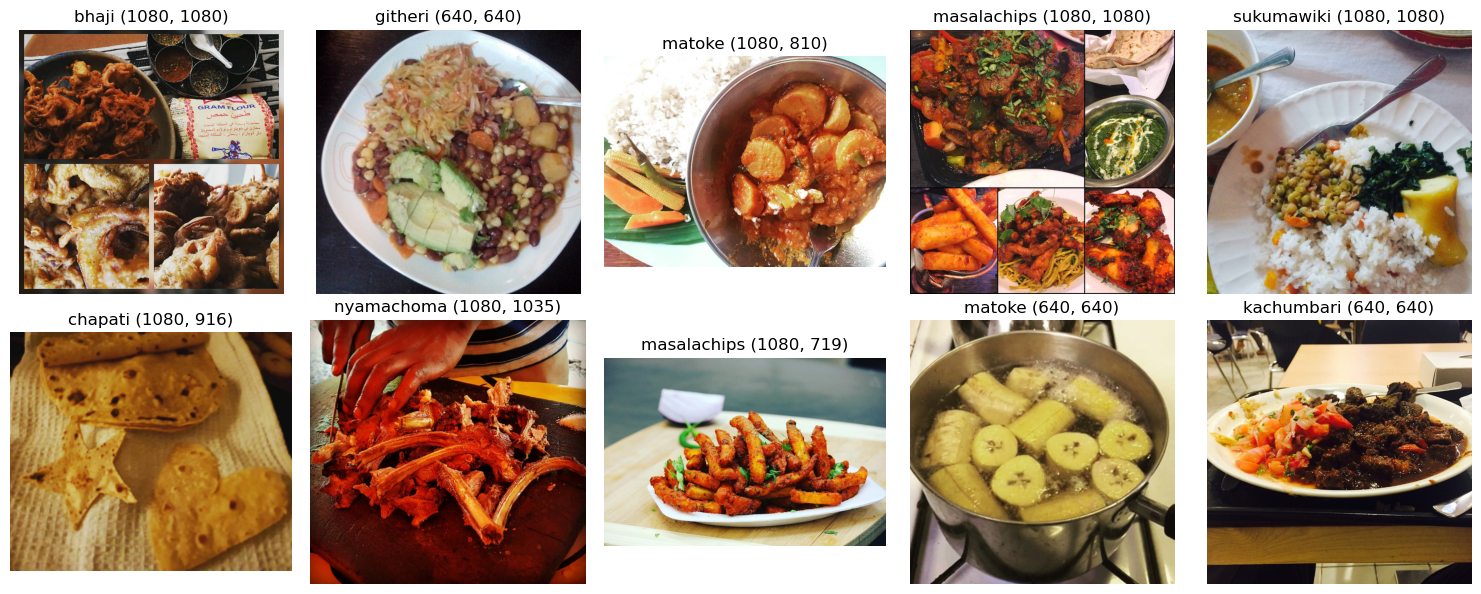

In [46]:
plt.figure(figsize=(15, 6))
for i, row in train.sample(10).reset_index(drop=True).iterrows():
    img_path = f'data/images/{row['id']}.jpg'
    img = Image.open(img_path)
    img_width, img_height = img.size
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'{row['class']} ({img_width}, {img_height})')
    plt.axis("off")

plt.tight_layout()
plt.show()

In [48]:
def image_preprocess_transforms(img_size):
    return T.Compose([
        T.Resize((img_size, img_size), antialias=True),
        T.ToTensor(),
    ])

In [ ]:
def get_resnet50(num_classes):
    model_resnet50 = resnet50(weights="DEFAULT")

    for params in model_resnet50.parameters():
        params.requires_grad = False

    for params in model_resnet50.layer4.parameters():
        params.requires_grad = True

    model_fc_in_features = model_resnet50.fc.in_features

    model_resnet50.fc = nn.Linear(in_features=model_fc_in_features, out_features=num_classes)

    return model_resnet50

In [7]:
model_resnet50 = resnet50(weights="DEFAULT")
for name, module in model_resnet50.named_children():
    print(name, "=", module.__class__.__name__)

conv1 = Conv2d
bn1 = BatchNorm2d
relu = ReLU
maxpool = MaxPool2d
layer1 = Sequential
layer2 = Sequential
layer3 = Sequential
layer4 = Sequential
avgpool = AdaptiveAvgPool2d
fc = Linear


In [14]:
summary(model_resnet50, input_size=(1, 3, 224, 224), depth=4)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [15]:
for name, module in model_resnet50.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

In [10]:
dummy = torch.randn(1, 3, 224, 224)

# Save graph
writer = SummaryWriter("runs/resnet50_graph")
writer.add_graph(model_resnet50, dummy)
writer.close()

In [12]:
%load_ext tensorboard
%tensorboard --logdir runs/resnet50_graph

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 996), started 0:02:59 ago. (Use '!kill 996' to kill it.)